In [52]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [53]:
def task_acc(R_list):
    dt = {}
    for i in range(len(R_list[0])):
        dt[f"train_{i}"] = [[] for _ in range(len(R_list[0][0]))]
        for j in range(len(R_list[0][0])):
            for R in R_list:
                dt[f"train_{i}"][j].append(R[j][i])
            tasks = np.array(dt[f"train_{i}"][j])
            #print(i, j, tasks)
            dt[f"train_{i}"][j] = (tasks.mean(), tasks.std())
            #print(i, j, dt[f"train_{i}"][j])
    return dt

def avg_acc(R_list):
    ACCS = []
    for R in R_list:
        T = R.shape[0]
        ACC = R[:, T-1].mean()
        ACCS.append(ACC)
    ACCS = np.array(ACCS)
    return ACCS.mean(), ACCS.std()

def bwt(R_list):
    BWTS = []
    for R in R_list:
        T = R.shape[0]
        diag = np.diag(R)
        final = R[:, T-1]
        BWT = (final[:-1] - diag[:-1]).mean()
        BWTS.append(BWT)
    BWTS = np.array(BWTS)
    return BWTS.mean(), BWTS.std()

def fwt(R_list):
    baseline = 0.1
    FWTS = []
    for R in R_list:
        FWT_raw = R[1:, :-1].diagonal().mean()
        FWTS.append(FWT_raw - baseline)
    FWTS = np.array(FWTS)
    return FWTS.mean(), FWTS.std()

def forgetting(R_list):
    FORGETS = []
    for R in R_list:
        T = R.shape[0]
        max_pre = R[:, :-1].max(axis=1)
        final = R[:, T-1]
        forget = max_pre - final
        forget = forget[:-1].mean()
        FORGETS.append(forget)
    FORGETS = np.array(FORGETS)
    return FORGETS.mean(), FORGETS.std()

In [54]:
import os
FOLDER_PATH = 'debug/mmlu-cl/'

file_names = [f for f in os.listdir(FOLDER_PATH) if '.npy' in f]
csv_names = [f for f in os.listdir(FOLDER_PATH) if '.csv' in f]

num_trials = 5
stats = {}
Rs = {}
for file_name in file_names:
    with open(FOLDER_PATH + file_name, 'rb') as f:
        R = np.load(f)
        name = file_name.split('_')[0]
        if name in Rs:
            Rs[name].append(R)
        else:
            Rs[name] = [R]
print(Rs)
for k, R_list in Rs.items():
    if k not in stats:
        stats[k] = {}
    for f in [task_acc, avg_acc, bwt, fwt, forgetting]:
        if f not in stats[k]:
            fname = str(f).split(' ')[1]
            stats[k][fname] = f(R_list)
        print(f"====== {file_name.split('_')[0]} ======")
        print("FULL R MATRIX")
        print(R)
        # print("STATS")
        # print(stats[k])


p_overheads = {}
for csv in csv_names:
    df = pd.read_csv(FOLDER_PATH + csv)
    projections  = df.filter(like='Projection', axis=1)
    name = csv.split('_')[0]
    print(name)
    if name in p_overheads:
        p_overheads[name].append(projections.iloc[-1].mean())    
    else:
        p_overheads[name] = [projections.iloc[-1].mean()]
for k, v in p_overheads.items():
    v = np.array(v)
    print(v)
    v = (v.mean(), v.std())
    stats[k]["projection"] = v

{'agem': [array([[0.2       , 0.28571429, 0.31428571],
       [0.29411765, 0.32352941, 0.14705882],
       [0.45      , 0.15      , 0.35      ]]), array([[0.22857143, 0.22857143, 0.31428571],
       [0.29411765, 0.26470588, 0.20588235],
       [0.45      , 0.05      , 0.3       ]]), array([[0.31428571, 0.22857143, 0.22857143],
       [0.14705882, 0.26470588, 0.35294118],
       [0.3       , 0.05      , 0.2       ]]), array([[0.2       , 0.22857143, 0.17142857],
       [0.32352941, 0.26470588, 0.29411765],
       [0.35      , 0.05      , 0.3       ]]), array([[0.34285714, 0.22857143, 0.37142857],
       [0.11764706, 0.26470588, 0.14705882],
       [0.3       , 0.05      , 0.3       ]])], 'naive': [array([[0.2       , 0.14285714, 0.17142857],
       [0.32352941, 0.32352941, 0.41176471],
       [0.35      , 0.2       , 0.3       ]]), array([[0.34285714, 0.31428571, 0.2       ],
       [0.11764706, 0.20588235, 0.20588235],
       [0.3       , 0.25      , 0.4       ]]), array([[0.22857143, 

[np.float64(0.2664705882352941), np.float64(0.27829131652661065), np.float64(0.24644257703081235), np.float64(0.23663865546218488)]
[np.float64(0.007309582713859977), np.float64(0.016922569925356), np.float64(0.034783848598337566), np.float64(0.040337262667072694)]


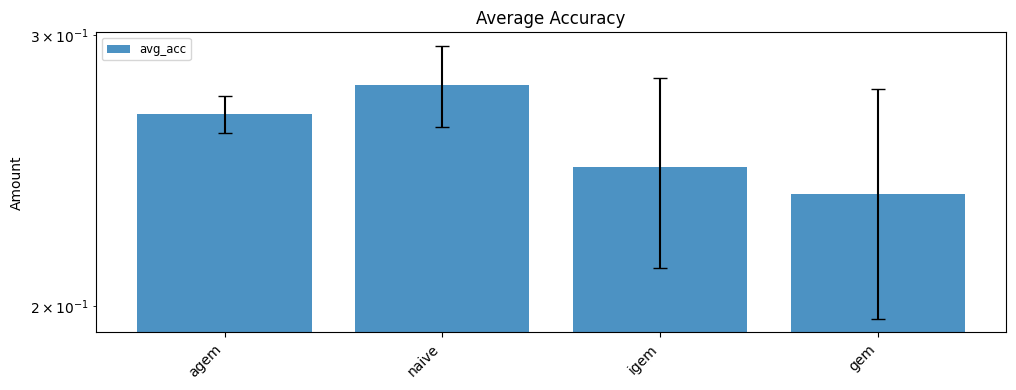

In [55]:
width = 0.5
fig, ax = plt.subplots(figsize=(10, 4))
means = [ v["avg_acc"][0] for k, v in stats.items() ]
stds = [v["avg_acc"][1] for k, v  in stats.items() ]
print(means)
print(stds)
x = np.arange(len(means))

plt.bar(x, means,
        yerr=stds,            
        capsize=5,             
        alpha=0.8,
        label='avg_acc')
ax.set_xticks(x)
ax.set_xticklabels(list(stats.keys()), rotation=45, ha='right')
ax.set_ylabel('Amount')
ax.set_title('Average Accuracy')
ax.legend(loc='upper left', fontsize='small')
plt.tight_layout()
plt.yscale('log')
plt.show()

In [56]:
print(stats)

{'agem': {'task_acc': {'train_0': [(np.float64(0.2571428571428571), np.float64(0.05993193418115152)), (np.float64(0.23529411764705882), np.float64(0.08524339262464375)), (np.float64(0.37), np.float64(0.0678232998312527))], 'train_1': [(np.float64(0.24), np.float64(0.022857142857142854)), (np.float64(0.27647058823529413), np.float64(0.02352941176470589)), (np.float64(0.06999999999999999), np.float64(0.039999999999999994))], 'train_2': [(np.float64(0.27999999999999997), np.float64(0.07091242083423346)), (np.float64(0.22941176470588234), np.float64(0.0819316957481419)), (np.float64(0.29), np.float64(0.04898979485566354))]}, 'avg_acc': (np.float64(0.2664705882352941), np.float64(0.007309582713859977)), 'bwt': (np.float64(-0.012100840336134455), np.float64(0.021912318611721587)), 'fwt': (np.float64(0.052647058823529415), np.float64(0.05296078068398764)), 'forgetting': (np.float64(0.032352941176470584), np.float64(0.028617116214637334)), 'projection': (np.float64(0.0007740367514391467), np.f

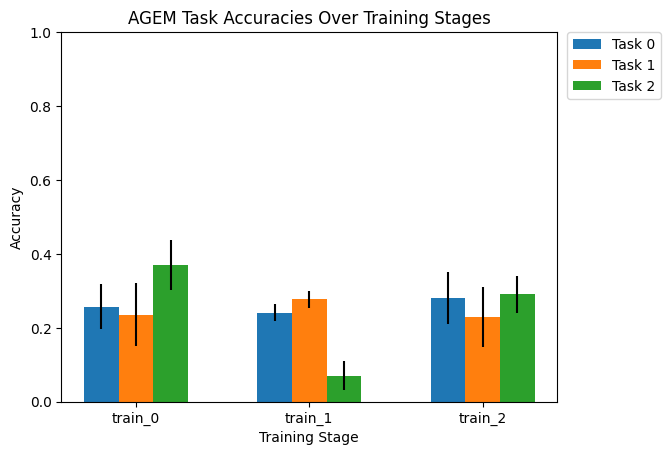

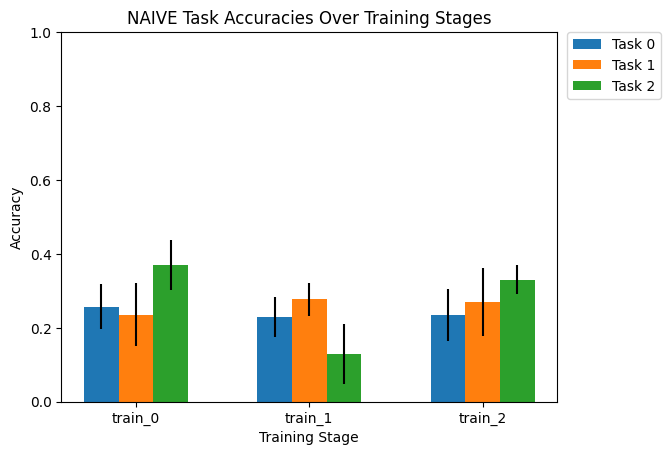

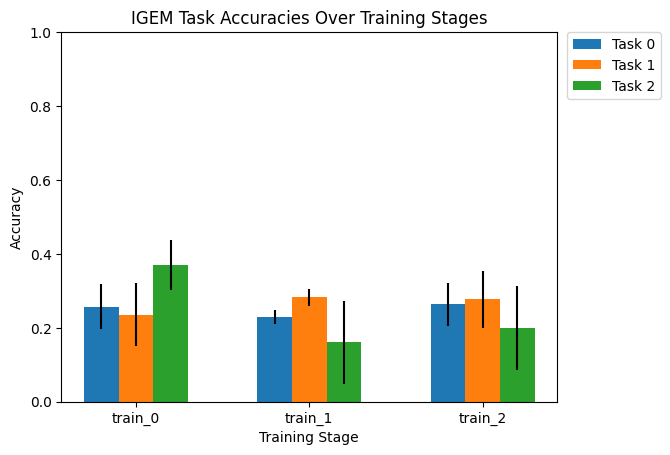

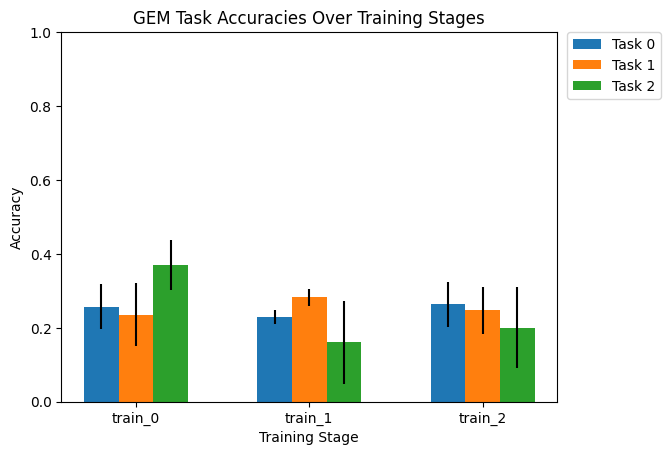

In [57]:
for method, vals in stats.items():
    data = vals['task_acc']
    stages = list(data.keys())
    n_stages = len(stages)
    n_tasks = len(data[stages[0]])
    
    x = np.arange(n_stages)
    bar_width = 0.2
    
    fig, ax = plt.subplots()
    for i in range(n_tasks):
        means = [data[stage][i][0] for stage in stages]
        stds = [data[stage][i][1] for stage in stages]
        ax.bar(x + i*bar_width, means, bar_width, yerr=stds, label=f'Task {i}')
    
    ax.set_xticks(x + bar_width*(n_tasks-1)/2)
    ax.set_xticklabels(stages)
    ax.set_ylim(0, 1)
    ax.set_xlabel('Training Stage')
    ax.set_ylabel('Accuracy')
    ax.set_title(f"{method.upper()} Task Accuracies Over Training Stages")
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    plt.show()

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (3,) and arg 1 with shape (4,).

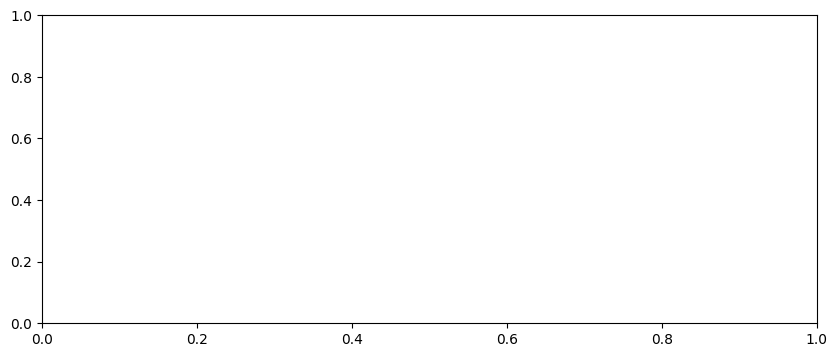

In [58]:
width = 0.5
fig, ax = plt.subplots(figsize=(10, 4))
bwt_means = [v["bwt"][0] for k, v in stats.items()]
bwt_stds = [v["bwt"][1] for k, v  in stats.items()]
fwt_means = [v["fwt"][0] for k, v in stats.items()]
fwt_stds = [v["fwt"][1] for k, v  in stats.items()]
fs_means = [v["forgetting"][0] for k, v in stats.items()]
fs_stds = [v["forgetting"][1] for k, v  in stats.items()]
x = np.arange(len(means))
ax.bar(x , bwt_means, width/3,yerr=bwt_stds,            
        capsize=5,             
        alpha=0.8, label='BWT')
ax.bar(x + width/3, fwt_means, width/3,yerr=fwt_stds,            
        capsize=5,             
        alpha=0.8, label='FWT')
ax.bar(x + 2*width/3, fs_means, width/3,yerr=fs_stds,            
        capsize=5,             
        alpha=0.8, label='avg_forgetting')
ax.set_xticks(x)
ax.set_xticklabels(list(stats.keys()), rotation=45, ha='right')
ax.set_ylabel('Amount')
ax.set_title('R-Matrix Metrics')
ax.legend(loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()



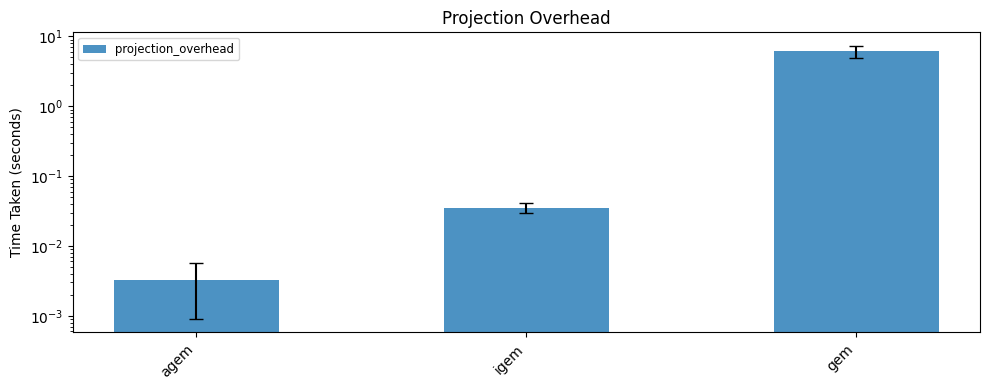

In [ ]:
width = 0.5
fig, ax = plt.subplots(figsize=(10, 4))
proj_means = [v["projection"][0] for k, v in stats.items()]
proj_stds = [v["projection"][1] for k, v in stats.items()]

x = np.arange(len(proj_means))
ax.bar(x , proj_means, width,yerr=[proj_stds],            
        capsize=5,             
        alpha=0.8, label='projection_overhead')
ax.set_xticks(x)
ax.set_xticklabels(list(stats.keys()), rotation=45, ha='right')
ax.set_ylabel('Time Taken (seconds)')
ax.set_title('Projection Overhead')
ax.legend(loc='upper left', fontsize='small')
plt.yscale('log')
plt.tight_layout()
plt.show()

